In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.expand_frame_repr', False)

In [2]:
bank = pd.read_csv("C:\\Users\\Can\\PycharmProjects\\pythonProject\\DataGlacierWeek9\\bank.csv", sep=';') # test data
bank_additional = pd.read_csv("C:\\Users\\Can\\PycharmProjects\\pythonProject\\DataGlacierWeek9\\bank-additional.csv", sep=';') # test data

bank_full = pd.read_csv("C:\\Users\\Can\\PycharmProjects\\pythonProject\\DataGlacierWeek9\\bank-full.csv", sep=';')
bank_additional_full = pd.read_csv("C:\\Users\\Can\\PycharmProjects\\pythonProject\\DataGlacierWeek9\\bank-additional-full.csv", sep=';')

bank = bank.sort_index(axis=1).sort_index(axis=0)
bank_additional = bank_additional.sort_index(axis=1).sort_index(axis=0)

bank_additional_full = bank_additional_full.sort_index(axis=1).sort_index(axis=0)
bank_full = bank_full.sort_index(axis=1).sort_index(axis=0)

print(bank_additional_full.shape)
print(bank_full.shape)

print(f"Different Variables of datasets: {bank_additional_full.columns.difference(bank_full.columns)}")

bank_additional_full.value_counts()
bank_full.value_counts()

df = pd.concat([bank_additional_full, bank_full], axis=0)
print(df.shape)


(41188, 21)
(45211, 17)
Different Variables of datasets: Index(['cons.conf.idx', 'cons.price.idx', 'day_of_week', 'emp.var.rate', 'euribor3m', 'nr.employed'], dtype='object')
(86399, 23)


In [3]:
def quick_look(dataframe, head=5):
    print("###################### SHAPE ##########################")
    print(dataframe.shape)

    print("########################## Describe #######################")
    print(dataframe.describe().T)

    print("####################### Variable Types ##################")
    print(dataframe.dtypes)

    print("###################### Head ##########################")
    print(dataframe.head(head))

    print("###################### Tail ##########################")
    print(dataframe.tail(head))

    print("###################### NA ##########################")
    print(dataframe.isna())

    print("###################### NUMBER OF NA ##########################")
    print(dataframe.isna().sum())


quick_look(df)

###################### SHAPE ##########################
(86399, 23)
########################## Describe #######################
                   count     mean      std       min      25%      50%      75%        max
age            86399.000   40.501   10.535    17.000   32.000   39.000   48.000     98.000
campaign       86399.000    2.670    2.948     1.000    1.000    2.000    3.000     63.000
cons.conf.idx  41188.000  -40.503    4.628   -50.800  -42.700  -41.800  -36.400    -26.900
cons.price.idx 41188.000   93.576    0.579    92.201   93.075   93.749   93.994     94.767
duration       86399.000  258.221  258.363     0.000  103.000  180.000  319.000   4918.000
emp.var.rate   41188.000    0.082    1.571    -3.400   -1.800    1.100    1.400      1.400
euribor3m      41188.000    3.621    1.734     0.634    1.344    4.857    4.961      5.045
nr.employed    41188.000 5167.036   72.252  4963.600 5099.100 5191.000 5228.100   5228.100
pdays          86399.000  479.865  483.829    -1.000 

In [4]:
def grab_col_names(dataframe):

    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    print("Categorical Variables", cat_cols)

    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtypes in [int, float]]
    print("Those variables numerical  variables", numerical_cols)

    numerical_but_categorical_variable = [col for col in dataframe.columns if
                                          dataframe[col].nunique() < 10 and dataframe[col].dtypes in [int, float]]
    print("Those variables numerical but categorical variables", numerical_but_categorical_variable)

    categorical_but_cardianal_variable = [col for col in dataframe.columns if
                                          dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) not in [int,
                                                                                                               float]]
    print("Those variables categorical variables but cardinal variables", categorical_but_cardianal_variable)

    cat_cols = cat_cols + numerical_but_categorical_variable
    cat_cols = [col for col in cat_cols if col not in categorical_but_cardianal_variable]
    print("All categorical variables are:", cat_cols)

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Eğer aynı sütun hem numerical_but_categorical_variable hem de categorical_but_cardianal_variable içindeyse, birini çıkaralım.
    for col in num_cols:
        if col in numerical_but_categorical_variable and col in categorical_but_cardianal_variable:
            categorical_but_cardianal_variable.remove(col)

    print("All numerical variables are:", num_cols)

    print(f"Number Of Observation: {dataframe.shape[0]}")
    print(f"Number Of Variable: {dataframe.shape[1]}")
    print(f"Number Of Categorical Variable: {len(cat_cols)}")
    print(f"Number Of Numerical Variable: {len(num_cols)}")
    print(f"Number Of Categorical but Cardinal Variables: {len(categorical_but_cardianal_variable)}")
    print(f"Number Of Numerical but Cardinal Variables: {len(numerical_but_categorical_variable)}")

    return cat_cols, num_cols, categorical_but_cardianal_variable

cat_cols, num_cols, categorical_but_cardianal_variable = grab_col_names(df)

Categorical Variables ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
Those variables numerical  variables ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed', 'balance', 'day']
Those variables numerical but categorical variables []
Those variables categorical variables but cardinal variables ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration', 'euribor3m', 'pdays', 'previous', 'balance', 'day']
All categorical variables are: ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
All numerical variables are: ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed', 'balance', 'day']
Number Of Observation: 86399
Number Of Variable: 23
Number Of Categorical Variable: 11
Number Of Numerical Variable: 7
Number Of Categorical but Cardinal Variables: 10
Number Of Numerical but Cardinal Variables: 0


                   count     mean      std       min       5%      10%      20%      30%      40%      50%      60%      70%      80%      90%      95%        max
cons.conf.idx  41188.000  -40.503    4.628   -50.800  -47.100  -46.200  -46.200  -42.700  -42.000  -41.800  -40.000  -36.400  -36.400  -36.100  -33.600    -26.900
cons.price.idx 41188.000   93.576    0.579    92.201   92.713   92.893   92.893   93.200   93.444   93.749   93.918   93.994   93.994   94.465   94.465     94.767
emp.var.rate   41188.000    0.082    1.571    -3.400   -2.900   -1.800   -1.800   -1.700   -0.100    1.100    1.100    1.400    1.400    1.400    1.400      1.400
euribor3m      41188.000    3.621    1.734     0.634    0.797    1.046    1.299    1.410    4.191    4.857    4.864    4.960    4.962    4.964    4.966      5.045
nr.employed    41188.000 5167.036   72.252  4963.600 5017.500 5076.200 5099.100 5099.100 5191.000 5191.000 5195.800 5228.100 5228.100 5228.100 5228.100   5228.100
balance        45211.0

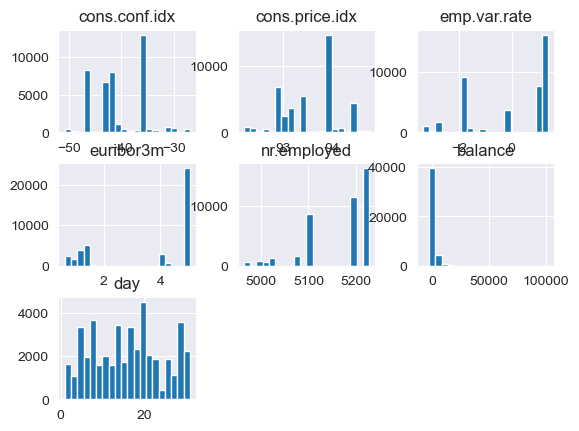

In [5]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


num_summary(df, num_cols, plot=True)

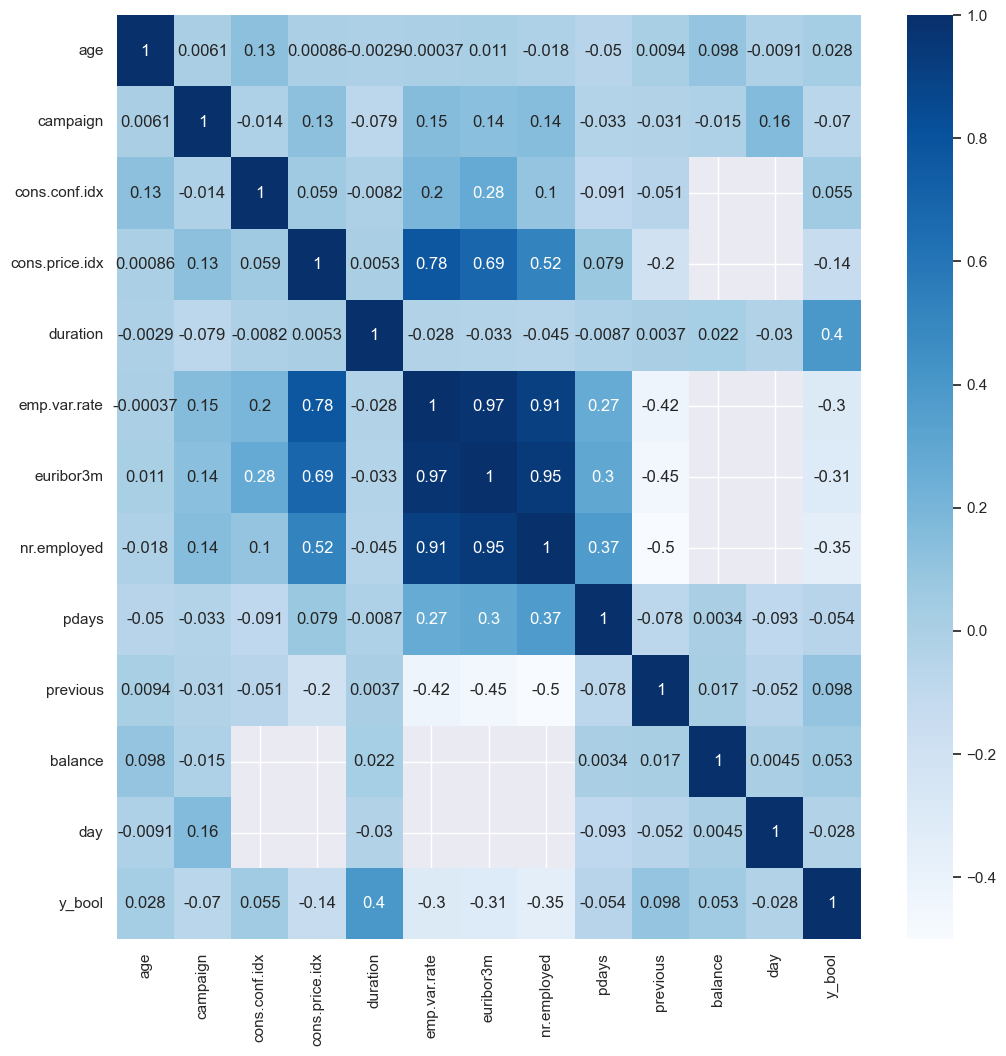

In [6]:
# Dataframe is inbalanced.

# Assign variable y values into boolean.
df["y_bool"] = df["y"].apply(lambda x: 1 if x == 'yes' else 0)

#Correlation analysis: Negative correlation is also considered following code block.
def cor_analiz_cardinals(dataframe):

    numeric_data = dataframe.select_dtypes(include=['float64', 'int64'])
    corr = numeric_data.corr()

    sns.set(rc={"figure.figsize": (12, 12)})
    sns.heatmap(corr, cmap="Blues", annot=True)
    plt.show()

cor_analiz_cardinals(df)

In [70]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    IQR = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * IQR
    low_limit = quartile1 - 1.5 * IQR
    return low_limit, up_limit
def check_outlier(dataframe, col_name):

    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

cat_cols, num_cols, categorical_but_cardianal_variable = grab_col_names(df)

for col in num_cols:
    print(f"{col}: {check_outlier(bank_additional, col)}")

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


for col in num_cols:
    print(col, grab_outliers(bank_additional, col))

cat_cols, num_cols, cat_but_car = grab_col_names(bank_additional)


Categorical Variables ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
Those variables numerical  variables ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed', 'balance', 'day']
Those variables numerical but categorical variables []
Those variables categorical variables but cardinal variables ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration', 'euribor3m', 'pdays', 'previous', 'balance', 'day']
All categorical variables are: ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
All numerical variables are: ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed', 'balance', 'day']
Number Of Observation: 86399
Number Of Variable: 24
Number Of Categorical Variable: 11
Number Of Numerical Variable: 7
Number Of Categorical but Cardinal Variables: 10
Number Of Numerical but Cardinal Variables: 0
cons.con

KeyError: 'balance'

In [71]:
def null_check_replace(dataframe):
    for col in dataframe.select_dtypes(include=['number']).columns:
        if dataframe[col].isnull().any() and col != "y_bool":
            if dataframe[col].dtype == 'object':
                print(f"{col}: {len(dataframe[dataframe[col].isnull()])} null values found in object column")
                dataframe[col].fillna(dataframe[col].mode().iloc[0], inplace=True)
            else:
                print(f"{col}: {len(dataframe[dataframe[col].isnull()])} null values found")
                dataframe[col].fillna(dataframe[col].median(), inplace=True)

    for col in dataframe.select_dtypes(include=['object']).columns:
        if dataframe[col].isnull().any() and col != "y_bool":
            print(f"{col}: {len(dataframe[dataframe[col].isnull()])} null values found in object column")
            dataframe[col].fillna(dataframe[col].mode().iloc[0], inplace=True)

    return dataframe
null_check_replace(df)



cons.conf.idx: 45211 null values
cons.price.idx: 45211 null values
day_of_week: 45211 null values
duration: 7 null values
emp.var.rate: 45211 null values
euribor3m: 45211 null values
nr.employed: 45211 null values
pdays: 15 null values
previous: 72517 null values
balance: 3514 null values
balance: 41188 null values
day: 41188 null values
y_bool: 76470 null values


In [7]:
bins = [-49, -40, -30, -19]

labels = ['Low_Inflation_PurchasingPower_PerMonth', 'Medium_Inflation_PurchasingPower_PerMonth', 'High_Inflation_PurchasingPower_PerMonth']

df['cons.conf.idx_cat'] = pd.cut(df['cons.conf.idx'], bins=bins, labels=labels, right=True)

bins = [91.0, 93.0, 94.0, 96.0]

# Kategori etiketleri
labels1 = ['Low_Price_Index_PurchasingPower_PerMonth', 'Medium_Price_Index_PurchasingPower_PerMonth',
          'High_Price_Index_PurchasingPower_PerMonth']

df['cons.price.idx_cat'] = pd.cut(df['cons.price.idx'],bins=bins, labels=labels1, right=True)

# Converting numerical cons.price.idx variable into categorical variable

df['contact'] = df['contact'].map({
    "cellular": "Cellular",
    "telephone": "Telephone"
})

# Generalization of  categorical education variable


# Understanding unknown education rows by using relation balance & education
# Grouping by the 'balance' variable and counting the occurrences of each 'education' category
# Assign basic.4y and basic.9y & basic.6y in to some class, professional course and hight school is summed into one variable
# which is called College Degree
# Assuming you have a DataFrame named bank_additional_model_data_1

# Apply function to update 'education' column
df["education"] = df["education"].apply(lambda x: 'basic' if 'basic' in x else x)

# Update 'education' column based on specific conditions
df["education"] = df["education"].apply(lambda x: 'Collage Degree' if 'professional.course' in x or 'high.school' in x else x)

df['job'] = df['job'].apply(lambda x: 1 if 'unemployed' not in x else 0)

mapping_dict = {'success': 1, 'failure': 0, 'nonexistent': np.random.choice([0, 1])}

# Apply the mapping to the 'poutcome' column
df["poutcome"] = df["poutcome"].map(mapping_dict)

# Create a dictionary to map values
mapping_dict_marital = {'divorced': 0, 'single': 0, 'married': 1, 'unknown': np.random.choice([0, 1])}

# Apply the mapping to the 'marital' column
df["marital"] = df["marital"].map(mapping_dict_marital)

cat_cols, num_cols, categorical_but_cardianal_variable = grab_col_names(df)
df.drop('y', axis=1,inplace=True)

Categorical Variables ['contact', 'day_of_week', 'default', 'education', 'housing', 'loan', 'month', 'y', 'cons.conf.idx_cat', 'cons.price.idx_cat']
Those variables numerical  variables ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed', 'poutcome', 'balance', 'day']
Those variables numerical but categorical variables ['poutcome']
Those variables categorical variables but cardinal variables ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration', 'euribor3m', 'pdays', 'previous', 'balance', 'day']
All categorical variables are: ['contact', 'day_of_week', 'default', 'education', 'housing', 'loan', 'month', 'y', 'cons.conf.idx_cat', 'cons.price.idx_cat', 'poutcome']
All numerical variables are: ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed', 'balance', 'day']
Number Of Observation: 86399
Number Of Variable: 26
Number Of Categorical Variable: 11
Number Of Numerical Variable: 7
Number Of Categorical but Cardinal Variable

In [8]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and 2 <= df[col].nunique() <= 12]

for col in binary_cols:
    df = label_encoder(df, col)

cat_cols, num_cols, categorical_but_cardianal_variable = grab_col_names(df)

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):


    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)

    return dataframe

df=one_hot_encoder(df, cat_cols, drop_first=True)

df.replace({True: 1, False: 0}, inplace=True)

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns


robust_scaler = RobustScaler()


scaled_values = robust_scaler.fit_transform(df[numerical_columns])


df[numerical_columns] = scaled_values


Categorical Variables ['cons.conf.idx_cat', 'cons.price.idx_cat']
Those variables numerical  variables ['cons.conf.idx', 'cons.price.idx', 'contact', 'day_of_week', 'default', 'education', 'emp.var.rate', 'euribor3m', 'housing', 'loan', 'month', 'nr.employed', 'poutcome', 'balance', 'day']
Those variables numerical but categorical variables ['contact', 'day_of_week', 'default', 'education', 'housing', 'loan', 'poutcome']
Those variables categorical variables but cardinal variables ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration', 'euribor3m', 'pdays', 'previous', 'balance', 'day']
All categorical variables are: ['cons.conf.idx_cat', 'cons.price.idx_cat', 'contact', 'day_of_week', 'default', 'education', 'housing', 'loan', 'poutcome']
All numerical variables are: ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'month', 'nr.employed', 'balance', 'day']
Number Of Observation: 86399
Number Of Variable: 25
Number Of Categorical Variable: 9
Number Of Numeric

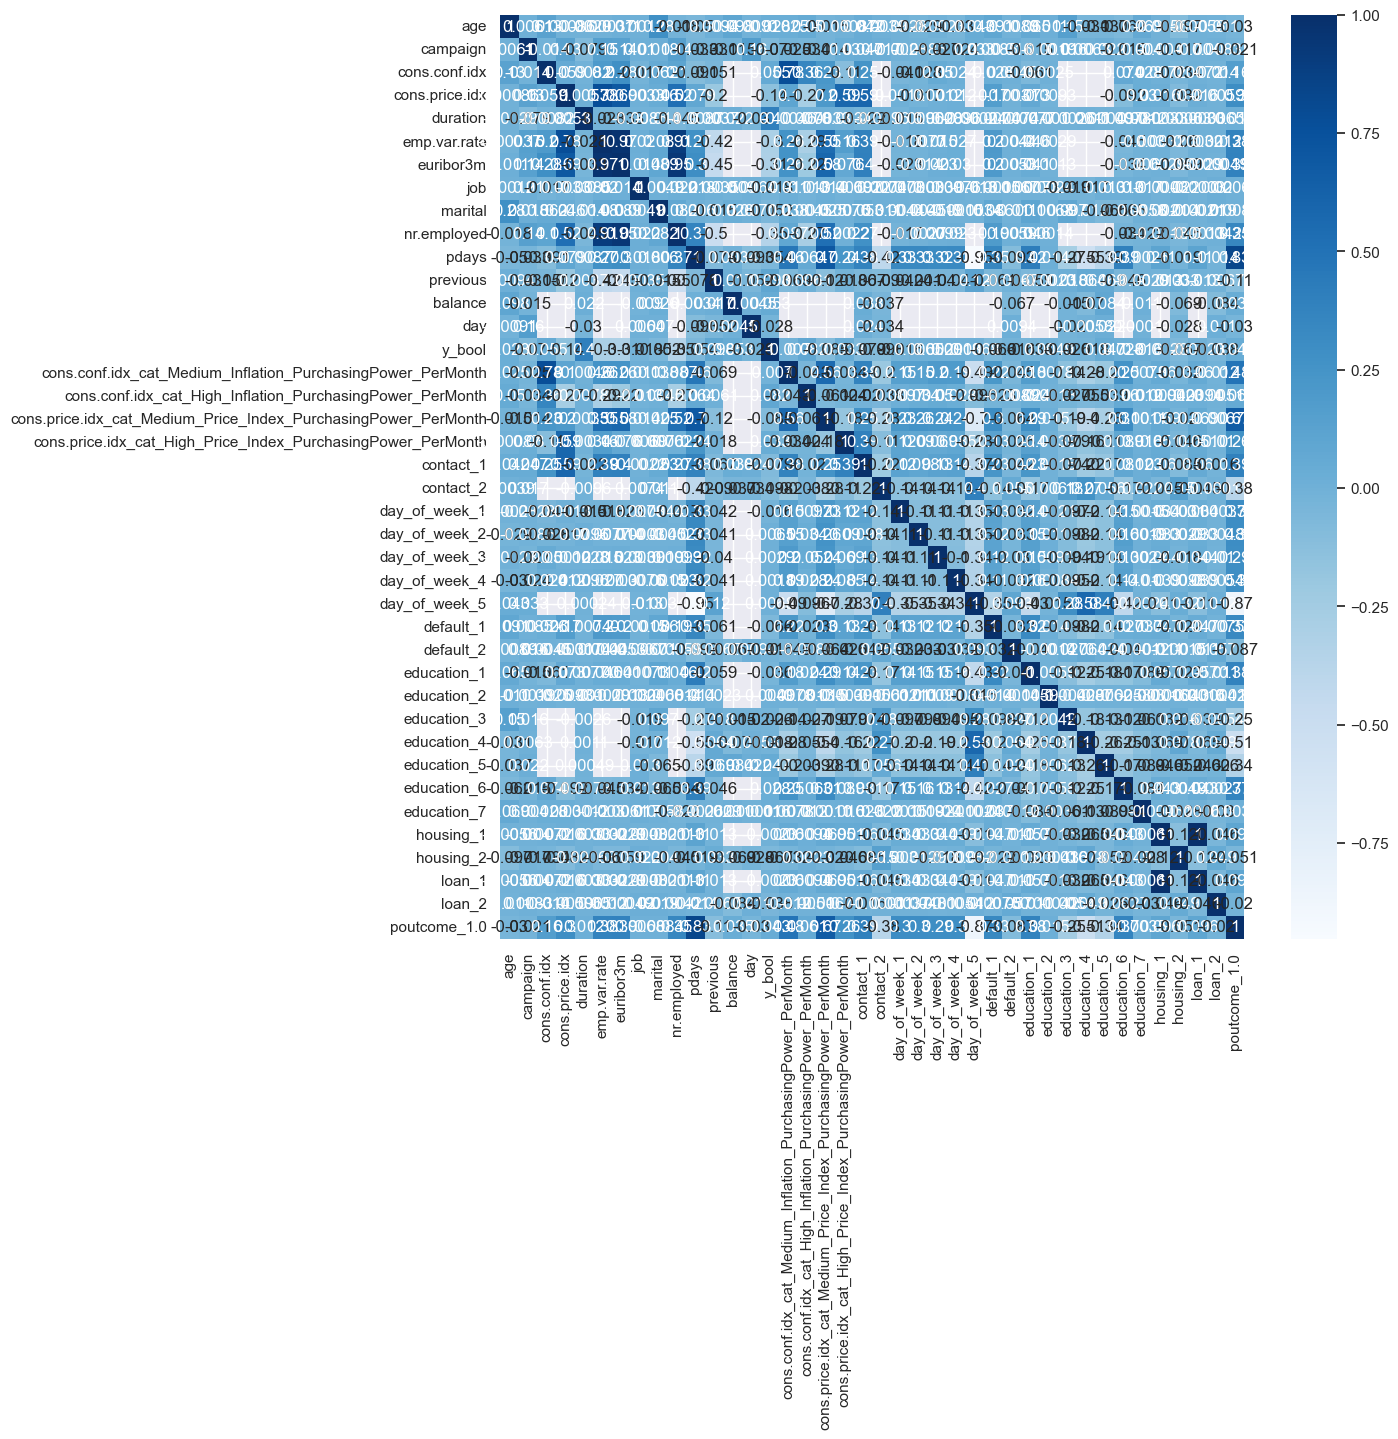

In [9]:
#Checking correlations after feature engineering
cor_analiz_cardinals(df)
#There is no high correlation between variables in negative or positive way. İt calls weak actually.

In [10]:
X = df.drop('y_bool', axis=1)
y = df['y_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53, shuffle=True, stratify=y)

In [ ]:
"""
# CatboosClassification Model Entegration
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())
0.8013756938147999
0.13955328119241553
0.7422180614158905
"""
"""
rf_model = RandomForestClassifier(random_state=17)
cv_results_rf = cross_validate(rf_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print("\nRandom Forest Results:")
print("Mean Accuracy:", cv_results_rf['test_accuracy'].mean())
print("Mean F1 Score:", cv_results_rf['test_f1'].mean())
print("Mean ROC AUC:", cv_results_rf['test_roc_auc'].mean())



rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "min_samples_split": [2, 5]
}

rf_model = RandomForestClassifier(random_state=17)


rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

rf_final = RandomForestClassifier(**rf_best_grid.best_params_, random_state=17).fit(X, y)

cv_results_rf = cross_validate(rf_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print("Random Forest Results:")
print("Mean Accuracy:", cv_results_rf['test_accuracy'].mean())
print("Mean F1 Score:", cv_results_rf['test_f1'].mean())
print("Mean ROC AUC:", cv_results_rf['test_roc_auc'].mean())

Random Forest Results:
Mean Accuracy: 0.8577996592684762
Mean F1 Score: 0.0740473944697647
Mean ROC AUC: 0.6887852227915563

"""


In [ ]:
##### Catboos Auc score higher than Randomforest.
# Now, lets check parameters more detaily.
# Hyperparametre Search By Using Optuna.

#### Best CatBoostClassifier Model
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [200, 500]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.1]),
        "depth": trial.suggest_categorical("depth", [3, 6]),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        # Add more CatBoost parameters here as needed
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True ,random_state=17)
    scores = []

    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        catboost_model = CatBoostClassifier(**params, verbose=False)
        catboost_model.fit(X_train, y_train)
        y_pred = catboost_model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    return np.mean(scores)  # Returning mean AUC across folds

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)


best_params = study.best_params

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
scores = {'accuracy': [], 'f1': [], 'roc_auc': []}

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_catboost_model = CatBoostClassifier(**best_params, random_state=17, verbose=False)
    best_catboost_model.fit(X_train, y_train)

    y_pred = best_catboost_model.predict(X_test)

    scores['accuracy'].append(accuracy_score(y_test, y_pred))
    scores['f1'].append(f1_score(y_test, y_pred))
    scores['roc_auc'].append(roc_auc_score(y_test, best_catboost_model.predict_proba(X_test)[:, 1]))

print("Mean Accuracy:", np.mean(scores['accuracy']))
print("Mean F1:", np.mean(scores['f1']))
print("Mean ROC AUC:", np.mean(scores['roc_auc']))